Эпоха 0: Функция потерь = 0.5707
Эпоха 100: Функция потерь = 0.2004
Эпоха 200: Функция потерь = 0.1939
Эпоха 300: Функция потерь = 0.1912
Эпоха 400: Функция потерь = 0.1903
Эпоха 500: Функция потерь = 0.1899
Сходимость достигнута на эпохе 576

Точность (Precision): 0.9351
Полнота (Recall): 1.0000
F1-мера: 0.9664


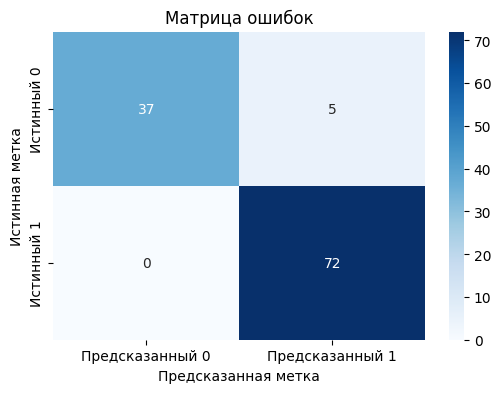

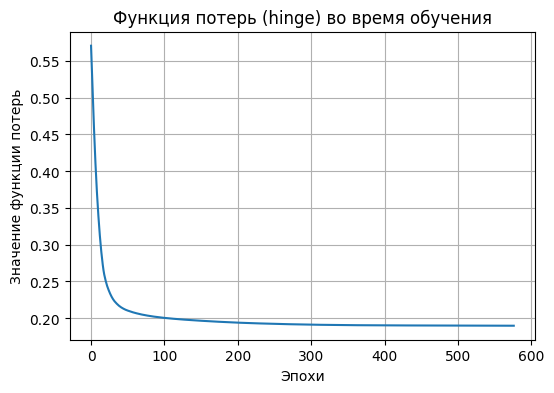

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

# --- данные ---
data = load_breast_cancer()
X = data.data
y = data.target



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- масштабирование ---
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# --- добавляем bias-столбец ---
X_train_norm = np.c_[np.ones(X_train_norm.shape[0]), X_train_norm]
X_test_norm  = np.c_[np.ones(X_test_norm.shape[0]),  X_test_norm]
m, n = X_train_norm.shape

# --- SVM: hinge-loss + L2 (без регуляризации для bias) ---
C = 0.6  # жёсткость к ошибкам (можно подвинтить)

def compute_cost(X, y, w):
    # y в {-1,+1}
    y_pm = np.where(y == 1, 1.0, -1.0)
    scores = X @ w
    margins = 1 - y_pm * scores
    hinge = np.maximum(0.0, margins).mean()
    reg = 0.5 * np.sum(w[1:]**2) 
    return reg + C * hinge

def gradient_descent(X, y, w, alpha=0.01, epochs=2000, tol=1e-6):
    m = X.shape[0]
    costs = []
    y_pm = np.where(y == 1, 1.0, -1.0)

    for epoch in range(epochs):
        scores = X @ w
        margins = 1 - y_pm * scores
        mask = (margins > 0).astype(float)

        reg_grad = w.copy()
        reg_grad[0] = 0.0

        grad = reg_grad + (-C / m) * (X.T @ (mask * y_pm))
        w -= alpha * grad

        cost = compute_cost(X, y, w)
        costs.append(cost)

        if epoch % 100 == 0:
            print(f"Эпоха {epoch}: Функция потерь = {cost:.4f}")

        if epoch > 1 and abs(costs[-1] - costs[-2]) < tol:
            print(f"Сходимость достигнута на эпохе {epoch}")
            break

    return w, costs

# --- обучение ---
w0 = np.zeros(n)
w_trained, costs = gradient_descent(X_train_norm, y_train, w0, alpha=0.01, epochs=2000, tol=1e-6)

# --- предсказание по знаку score ---
def predict(X, w, threshold=0.0):
    scores = X @ w
    return (scores >= threshold).astype(int)

y_pred_train = predict(X_train_norm, w_trained)
y_pred_test  = predict(X_test_norm,  w_trained)

train_accuracy = np.mean(y_pred_train == y_train) * 100
test_accuracy  = np.mean(y_pred_test  == y_test)  * 100
# при желании можно распечатать:
# print(f"Train acc: {train_accuracy:.2f}%  |  Test acc: {test_accuracy:.2f}%")

# --- метрики и визуализация ---
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

cm_test = confusion_matrix(y_test, y_pred_test)

precision = cm_test[1,1] / (cm_test[1,1] + cm_test[0,1]) if (cm_test[1,1] + cm_test[0,1]) > 0 else 0
recall    = cm_test[1,1] / (cm_test[1,1] + cm_test[1,0]) if (cm_test[1,1] + cm_test[1,0]) > 0 else 0
f1_score  = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nТочность (Precision): {precision:.4f}")
print(f"Полнота (Recall): {recall:.4f}")
print(f"F1-мера: {f1_score:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предсказанный 0', 'Предсказанный 1'],
            yticklabels=['Истинный 0', 'Истинный 1'])
plt.title('Матрица ошибок')
plt.ylabel('Истинная метка')
plt.xlabel('Предсказанная метка')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(costs)
plt.title('Функция потерь (hinge) во время обучения')
plt.xlabel('Эпохи')
plt.ylabel('Значение функции потерь')
plt.grid(True)
plt.show()
